# Tutorial 13 (JAX): Generative Adversarial Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial13/GAN.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial13/GAN.ipynb)     
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial13)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial13/GAN.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We will report a speed comparison between the PyTorch and JAX/Flax implementation here soon.
    
| Models                |   PyTorch   |     JAX     |
|-----------------------|:-----------:|:-----------:|
| Simple GAN            |  -min  -sec |  -min  -sec |
| StyleGAN 2            |  -min  -sec |  -min  -sec |

---

TODO: Intro to GANs

In [1]:
## Standard libraries
import os
import math
import numpy as np
from typing import Any
from collections import defaultdict
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial13_jax"

print("Device:", jax.devices()[0])

/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Device: gpu:0


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial13/"
# Files to download
pretrained_files = []
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:
# Transformations applied on each image => bring them into a numpy array and normalize
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255. * 2. - 1. # Bring between -1 and 1
    img = img[..., None]  # Make image [28, 28, 1]
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True,
                      transform=image_to_numpy, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))
# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False,
                 transform=image_to_numpy, download=True)

# We define a set of data loaders that we can use for various purposes
train_loader = data.DataLoader(train_set,
                               batch_size=32,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                             drop_last=False, num_workers=0, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False,
                              drop_last=False, num_workers=0, collate_fn=numpy_collate)

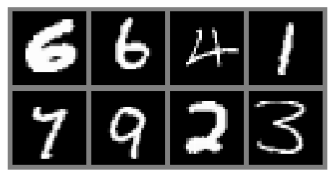

In [4]:
def imgs_to_grid(imgs, nrow=-1, ncol=-1):
    imgs = jax.device_get(imgs)
    if isinstance(imgs, (list, tuple)):
        imgs = np.stack(imgs, axis=0)
    num_imgs = imgs.shape[0]
    if nrow == -1 or ncol == -1:
        if num_imgs < 4 or num_imgs % 4 == 0:
            nrow = min(num_imgs, 4)
            ncol = int(math.ceil(num_imgs/nrow))
        else:
            nrow = num_imgs
            ncol = 1
    imgs = np.pad(imgs, pad_width=[(0,0), (1,1), (1,1), (0,0)], constant_values=0)
    imgs = np.reshape(imgs, (nrow, ncol, *imgs.shape[1:]))
    imgs = np.transpose(imgs, (1, 2, 0, 3, 4))
    imgs = np.reshape(imgs, (imgs.shape[0]*imgs.shape[1], imgs.shape[2]*imgs.shape[3], -1))
    imgs = np.pad(imgs, pad_width=[(1,1), (1,1), (0,0)], constant_values=0)
    imgs = (imgs + 1.) / 2.
    imgs = np.squeeze(imgs, axis=-1)
    return imgs, (nrow, ncol)

def show_imgs(imgs, show=True):
    imgs, (nrow, ncol) = imgs_to_grid(imgs)
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(imgs, interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## A simple GAN on MNIST

In [5]:
class MNISTGenerator(nn.Module):
    c_hid : int
    latent_dim : int
    c_out : int = 1
    
    @nn.compact
    def __call__(self, z, **kwargs):
        if len(z.shape) == 2:
            z = z[:,None,None,:]
        conv = partial(nn.ConvTranspose, 
                       kernel_size=(4, 4), 
                       kernel_init=nn.initializers.he_normal())
        z = conv(features=4*self.c_hid, strides=(1, 1), padding='VALID')(z) # 4x4
        z = nn.leaky_relu(z, 0.2) * np.sqrt(2)
        z = conv(features=2*self.c_hid, kernel_size=(4, 4), strides=(2, 2))(z) # 8x8
        z = nn.leaky_relu(z, 0.2) * np.sqrt(2)
        z = conv(features=self.c_hid, kernel_size=(4, 4), strides=(2, 2))(z) # 16x16
        z = nn.leaky_relu(z, 0.2) * np.sqrt(2)
        z = conv(features=self.c_hid, kernel_size=(4, 4), strides=(2, 2), padding=0)(z) # 28x28
        z = nn.leaky_relu(z, 0.2) * np.sqrt(2)
        z = conv(features=self.c_out, kernel_size=(1, 1))(z)
        z = nn.tanh(z)
        return z
    
    def generate(self, rng, batch_size):
        z = random.normal(rng, (batch_size, self.latent_dim))
        return self.__call__(z)

In [6]:
rng = random.PRNGKey(0)
inp = random.normal(rng, (256, 64))
model = MNISTGenerator(c_hid=32, c_out=1, latent_dim=inp.shape[-1])
params = model.init(random.PRNGKey(1), inp)
out = model.apply(params, inp)
print(out.shape)
print(out.std(axis=0).mean())
_ = model.bind(params).generate(rng, 1)
print(params['params']['ConvTranspose_0']['kernel'].shape)

(256, 28, 28, 1)
0.13224345
(4, 4, 64, 128)


In [7]:
class MNISTDiscriminator(nn.Module):
    c_hid : int
    c_in : int = 1
        
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2, padding=3)(x)  # 28x28 => 16x16
        x = nn.leaky_relu(x, 0.2)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 16x16 => 8x8
        x = nn.leaky_relu(x, 0.2)
        x = nn.Conv(features=4*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 8x8 => 4x4
        x = nn.leaky_relu(x, 0.2)
        x = nn.Conv(features=1, kernel_size=(4, 4), padding=0)(x)
        x = jnp.squeeze(x, axis=(1,2,3))
        return x

In [8]:
rng = random.PRNGKey(0)
inp = random.normal(rng, (64, 28, 28, 1))
model = MNISTDiscriminator(c_hid=32, c_in=1)
params = model.init(rng, inp)
out = model.apply(params, inp)
print(out.shape)

(64,)


In [9]:
def generator_loss(generator, discriminator_bd, batch_size, rng, params_gen):
    model_rng, z_rng = random.split(rng)
    z = random.normal(z_rng, (batch_size, generator.latent_dim))
    x_fake = generator.apply(params_gen, z, rng=model_rng)
    D_fake = discriminator_bd(x_fake)
    loss = -nn.log_sigmoid(D_fake).mean()
    return loss, (x_fake, z)

In [10]:
def discriminator_loss(discriminator, generator_bd, x_real, rng, params_dis):
    x_fake = generator_bd.generate(rng, batch_size=x_real.shape[0])
    x = jnp.concatenate([x_real, x_fake], axis=0)
    D_out = discriminator.apply(params_dis, x)
    D_real, D_fake = jnp.split(D_out, 2, axis=0)
    loss_real = -nn.log_sigmoid(D_real).mean()
    loss_fake = -nn.log_sigmoid(-D_fake).mean()
    acc = ((D_real > 0).mean() + (D_fake < 0).mean()) / 2.
    loss = (loss_real + loss_fake) / 2.
    return loss, (acc, loss_real, loss_fake)

In [11]:
class GenerateCallback:
    
    def __init__(self, generator, every_n_epochs=1):
        self.every_n_epochs = every_n_epochs
        self.gen_fn = jax.jit(lambda p: generator.bind(p).generate(random.PRNGKey(0), batch_size=64))
        
    def log_generations(self, params_gen, logger, epoch):
        if epoch % self.every_n_epochs == 0:
            gen_imgs = self.gen_fn(params_gen)
            gen_imgs, _ = imgs_to_grid(gen_imgs, nrow=8, ncol=8)
            logger.add_image('Generations', gen_imgs[None], global_step=epoch)

In [12]:
class TrainState(train_state.TrainState):
    rng : Any = None
    ema_params : Any = None

In [13]:
class TrainerModule:

    def __init__(self, model_name, lr_gen=1e-4, lr_dis=2e-4, ema_factor=0.9, seed=42, **model_kwargs):
        super().__init__()
        self.model_name = model_name
        self.lr_gen = lr_gen
        self.lr_dis = lr_dis
        self.ema_factor = ema_factor
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.create_models(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.generate_callback = GenerateCallback(self.generator, every_n_epochs=1)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model()
        
    def create_models(self, c_hid, latent_dim, **kwargs):
        self.discriminator = MNISTDiscriminator(c_hid=c_hid)
        self.generator = MNISTGenerator(c_hid=c_hid, latent_dim=latent_dim)

    def create_functions(self):
        # Training function
        def train_step(state_gen, state_dis, batch):
            x_real, _ = batch
            rng_gen, step_gen_rng = random.split(state_gen.rng)
            rng_dis, step_dis_rng = random.split(state_dis.rng)
            # Generator gradients
            loss_fn_gen = lambda p: generator_loss(self.generator,
                                                   self.discriminator.bind(state_dis.params),
                                                   batch_size=x_real.shape[0],
                                                   rng=step_gen_rng,
                                                   params_gen=p)
            (G_loss, _), grads_gen = jax.value_and_grad(loss_fn_gen, 
                                                        has_aux=True)(state_gen.params)
            # Discriminator gradients
            loss_fn_dis = lambda p: discriminator_loss(self.discriminator,
                                                       self.generator.bind(state_gen.ema_params),
                                                       x_real,
                                                       rng=step_dis_rng,
                                                       params_dis=p)
            D_out, grads_dis = jax.value_and_grad(loss_fn_dis,
                                                  has_aux=True)(state_dis.params)
            D_loss, (D_acc, D_loss_real, D_loss_fake) = D_out
            # Params updates
            update_ema = lambda state: tree_map(lambda e, p: e * self.ema_factor + p * (1 - self.ema_factor), 
                                                state.ema_params, 
                                                state.params)
            state_gen = state_gen.apply_gradients(grads=grads_gen, rng=rng_gen, ema_params=update_ema(state_gen))
            state_dis = state_dis.apply_gradients(grads=grads_dis, rng=rng_dis, ema_params=update_ema(state_dis))
            # Metrics
            metrics = {'G_loss': G_loss, 'D_loss': D_loss, 'D_acc': D_acc,
                       'D_loss_real': D_loss_real, 'D_loss_fake': D_loss_fake}
            return state_gen, state_dis, metrics
        self.train_step = jax.jit(train_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng_gen, rng_dis, z_rng, init_gen_rng, for_gen_rng, init_dis_rng = jax.random.split(rng, 6)
        z = random.normal(z_rng, (128, self.generator.latent_dim))
        gen_out, params_gen = self.generator.init_with_output(init_gen_rng, z, rng=for_gen_rng)
        params_dis = self.discriminator.init(init_dis_rng, gen_out)
        # Initialize optimizer
        optimizer_gen = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(self.lr_gen, b1=0.5, b2=0.9)
        )
        optimizer_dis = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(self.lr_dis, b1=0.5, b2=0.9)
        )
        # Initialize training state
        self.state_gen = TrainState.create(apply_fn=self.generator.apply, 
                                           params=params_gen,
                                           ema_params=params_gen,
                                           tx=optimizer_gen,
                                           rng=rng_gen)
        self.state_dis = TrainState.create(apply_fn=self.discriminator.apply,
                                           params=params_dis,
                                           ema_params=params_dis,
                                           tx=optimizer_dis,
                                           rng=rng_dis)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_eval = 1e6
        self.generate_callback.log_generations(self.state_gen.params, logger=self.logger, epoch=0)
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            self.generate_callback.log_generations(self.state_gen.params, logger=self.logger, epoch=epoch_idx)
            if epoch_idx % 10 == 0:
                self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss
        losses = defaultdict(list)
        dataset_size = len(train_loader)
        for batch_idx, batch in enumerate(train_loader):
            self.state_gen, self.state_dis, metrics = self.train_step(self.state_gen, self.state_dis, batch)
            for key in metrics:
                losses[key].append(metrics[key])
                if (batch_idx + 1) % 50 == 0 or batch_idx + 1 == dataset_size:
                    metric_np = np.stack(jax.device_get(losses.pop(key)))
                    avg_metric = metric_np.mean()
                    self.logger.add_scalar(f'train/{key}', avg_metric, global_step=epoch*dataset_size+batch_idx+1)

    def save_model(self, step=0):
        # Save current model at certain training iteration
        params = {
            'generator': self.state_gen.params,
            'discriminator': self.state_dis.params
        }
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=params, 
                                    prefix=f'{self.model_name}_', step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None, prefix=f'{self.model_name}_')
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state_gen = TrainState.create(apply_fn=self.state_gen.apply_fn, params=params['generator'], tx=self.state_gen.tx, rng=self.state_gen.rng)
        self.state_dis = TrainState.create(apply_fn=self.state_dis.apply_fn, params=params['discriminator'], tx=self.state_dis.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [14]:
def train_model(*args, trainer_class=TrainerModule, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = trainer_class(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    return trainer

In [15]:
# trainer = train_model(model_name='SimpleMNIST', 
#                       c_hid=16, latent_dim=64,
#                       lr_gen=2e-4, lr_dis=2e-4, ema_factor=0.0)

## StyleGAN 2

In [147]:
class ModulatedConv(nn.Module):
    features : int
    kernel_size : int = 3
    demodulate : bool = True
    eps : float = 1e-8
        
    @nn.compact
    def __call__(self, x, s):
        B, H, W, C = x.shape
        # Create convolutional kernel
        w = self.param('kernel', nn.initializers.lecun_normal(), # nn.initializers.normal(stddev=1.0),
                       (self.kernel_size, self.kernel_size, C, self.features))
        
        # Weight kernel by modulation s
        w = w[None] * s[:,None,None,:,None]
        
        # If true, we demodulate the kernel
        if self.demodulate:
            # Estimate 1 / l2 norm of w, eps for stabilization
            d = jax.lax.rsqrt((w ** 2).sum(axis=(1, 2, 3), keepdims=True) + self.eps)
            w = w * d
        
        # Apply convolution to input. Since each input has a different conv kernel,
        # we define different 'groups' in the convolution which do not communicate
        # For this, we flatten the batch and channel dimension
        x = jnp.transpose(x, (1, 2, 0, 3))
        x = x.reshape(1, H, W, B * C)
        # Same we do with w
        w = jnp.transpose(w, (1, 2, 3, 0, 4))
        w = w.reshape(*w.shape[:3], B * self.features)
        # Apply convolution with B groups
        
        ## TODO: CHECK OUT BATCH GROUP COUNT
        x = jax.lax.conv_general_dilated(x, w, 
                                         window_strides=(1, 1),
                                         padding='SAME',
                                         dimension_numbers=nn.linear._conv_dimension_numbers(x.shape),
                                         feature_group_count=B)
        # print('W', w.std(), 'S', s.std())
        # print('X', x.std())
        # Reshape x to original form
        x = x.reshape(H, W, B, self.features)
        x = jnp.transpose(x, (2, 0, 1, 3))
        return x

In [148]:
rng = random.PRNGKey(0)
x = random.normal(rng, (128, 14, 14, 64))
s = jnp.exp(random.normal(rng, (x.shape[0], x.shape[-1])))
conv = ModulatedConv(features=64)
params = conv.init(rng, x, s)
out = conv.apply(params, x, s)
print(out.shape)
print(out.std())
s = s.at[2,:].set(0.1)
out2 = conv.apply(params, x, s)
print((out != out2).any(axis=(1, 2, 3)))

(128, 14, 14, 64)
0.9518902
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [149]:
class GeneratorLayer(nn.Module):
    features : int
        
    @nn.compact
    def __call__(self, x, z, rng):
        B, H, W, C = x.shape
        # Map latent vector to style factors for this layer
        style = nn.Dense(features=C,
                         # kernel_init=nn.initializers.normal(stddev=1.0),
                         bias_init=nn.initializers.ones)(z)
        # Apply modulated conv on the input with style
        x = ModulatedConv(self.features,
                          kernel_size=3,
                          demodulate=True)(x, style)
        # print('X after mod', x.std())
        # Add bias
        bias = self.param('bias',
                          nn.initializers.zeros,
                          (1, 1, 1, self.features))
        x = x + bias
        # Apply random noise
        noise = random.normal(rng, (B, H, W, 1))
        noise_scaling = self.param('noise_scaling',
                                   nn.initializers.zeros,
                                   (1, 1, 1, self.features))
        x = x + noise * noise_scaling
        # Activation function
        x = nn.leaky_relu(x, 0.2) * np.sqrt(2)
        return x

In [150]:
class Blur(nn.Module):
    
    def setup(self):
        kernel = jnp.array([1, 2, 1])
        kernel = kernel[None, :] * kernel[:, None]
        kernel = kernel / kernel.sum()
        kernel = kernel[:,:,None,None]
        self.blur_kernel = kernel
    
    def __call__(self, x):
        x = jnp.pad(x, ((0, 0), (1, 1), (1, 1), (0, 0)), 'edge')
        x = jax.lax.conv_general_dilated(x, jnp.tile(self.blur_kernel, [1, 1, 1, x.shape[-1]]),
                                         window_strides=(1, 1),
                                         padding='VALID',
                                         dimension_numbers=nn.linear._conv_dimension_numbers(x.shape),
                                         feature_group_count=x.shape[-1])
        return x

In [151]:
inp = random.normal(random.PRNGKey(0), (4, 3, 3, 2))
module = Blur()
_ = module.init(random.PRNGKey(0), inp)
out = module.apply({}, inp)
out = module.apply({}, out)
out.shape
print(out)

[[[[-0.8627592  -0.05157972]
   [-0.6586386  -0.26832023]
   [-0.25579616 -0.42787594]]

  [[-0.45864317 -0.26274782]
   [-0.2933797  -0.5274103 ]
   [-0.01100415 -0.69180477]]

  [[-0.23446114 -0.5106406 ]
   [-0.03690636 -0.7680731 ]
   [ 0.22558092 -0.9408488 ]]]


 [[[ 0.1911506  -0.0496189 ]
   [ 0.17381474 -0.17504251]
   [ 0.3115761  -0.3291268 ]]

  [[ 0.09033134  0.12041623]
   [ 0.36657652  0.03913856]
   [ 0.7436601  -0.1003627 ]]

  [[ 0.08979694  0.23039237]
   [ 0.58170474  0.23877367]
   [ 1.1616632   0.15215045]]]


 [[[ 0.5947954  -0.21732825]
   [ 0.24929968 -0.28804177]
   [-0.17831519 -0.3508661 ]]

  [[ 0.30982223  0.288464  ]
   [ 0.10423411  0.02131559]
   [-0.21893662 -0.3163483 ]]

  [[-0.07675925  0.853766  ]
   [-0.15501294  0.41077104]
   [-0.3694581  -0.16698697]]]


 [[[ 0.59077287 -0.47339386]
   [ 0.4552713  -0.09232306]
   [ 0.23564138  0.17344531]]

  [[ 0.4805568  -0.6653577 ]
   [ 0.5736375  -0.31587136]
   [ 0.6075451  -0.07183921]]

  [[ 0.27531233

In [152]:
class RGBLayer(nn.Module):
    c_out : int
    
    @nn.compact
    def __call__(self, x, prev_rgb, z):
        B, H, W, C = x.shape
        
        # print('X', x.std(), 'Z', z.std())
        
        style = nn.Dense(features=C,
                         # kernel_init=nn.initializers.normal(stddev=1.0),
                         bias_init=nn.initializers.ones)(z)
        x = ModulatedConv(features=self.c_out, 
                          kernel_size=1,
                          demodulate=False)(x, style)
        
        if prev_rgb is not None:
            # In some implementation, the previous image is additionally blurred
            prev_rgb = jax.image.resize(prev_rgb, (B, H, W, self.c_out), 'bilinear')
            prev_rgb = Blur()(prev_rgb)
            x = x + prev_rgb
        
        return x

In [153]:
class GeneratorBlock(nn.Module):
    features : int
    c_out : int = 3
    num_layers : int = 2
    upsample : bool = True
        
    @nn.compact
    def __call__(self, x, prev_rgb, z, rng):
        B, H, W, C = x.shape
        if self.upsample:
            x = jax.image.resize(x, (B, H*2, W*2, C), 'bilinear')
        
        for _ in range(self.num_layers):
            rng, layer_rng = random.split(rng)
            # print('X in (Gen layer)', x.std())
            x = GeneratorLayer(features=self.features)(x, z, layer_rng)
            # print('X out (Gen layer)', x.std())
        
        rgb = RGBLayer(c_out=self.c_out)(x, prev_rgb, z)
        # print('RGB', rgb.std())
        return x, rgb

In [154]:
class StyleLinear(nn.Module):
    features: int
    lr_mul : float = 0.1
    
    @nn.compact
    def __call__(self, x):
        w = self.param('weight',
                       nn.initializers.normal(stddev=1.0),
                       (x.shape[-1], self.features))
        b = self.param('bias',
                       nn.initializers.zeros,
                       (self.features,))
        w = w * self.lr_mul
        b = b * self.lr_mul
        x = jnp.matmul(x, w) + b[None]
        return x

In [155]:
class StyleNet(nn.Module):
    latent_dim : int
    num_layers : int
    lr_mul : float = 0.1
        
    @nn.compact
    def __call__(self, z):
        # z = z / jnp.linalg.norm(z, axis=-1, keepdims=True)
        z = z * jax.lax.rsqrt(jnp.mean(z ** 2, axis=1, keepdims=True) + 1e-8)
        # print(z.std())
        for idx in range(self.num_layers):
            z = StyleLinear(features=self.latent_dim,
                            lr_mul=self.lr_mul)(z)
            z = nn.leaky_relu(z, 0.2) * np.sqrt(2)
            # print(idx, z.std())
        return z

In [156]:
class StyleGANGenerator(nn.Module):
    image_size : int
    latent_dim : int = 256
    base_c_hid : int = 16
    max_c_hid : int = 256
    c_out : int = 3
    num_style_layers : int = 8
    is_mnist : bool = False
    mlp_lr_mul : float = 0.01
    
    def setup(self):
        num_layers = int(np.log2(self.image_size) - 1)
        c_hid = [min(self.max_c_hid, self.base_c_hid * (2 ** i)) for i in range(num_layers)][::-1]
        self.init_const = self.param('init_const',
                                     nn.initializers.normal(stddev=1.0),
                                     (1, 4, 4, c_hid[0]))
        self.init_conv = nn.Conv(features=c_hid[0], kernel_size=(3, 3), padding='SAME')
        self.style_net = StyleNet(latent_dim=self.latent_dim,
                                  num_layers=self.num_style_layers,
                                  lr_mul=self.mlp_lr_mul)
        self.blocks = [GeneratorBlock(features=c_hid[i],
                                      upsample=(i > 0),
                                      c_out=self.c_out)
                       for i in range(num_layers)]
        
    def __call__(self, z, rng):
        z = self.style_net(z)
        # print('Z', z.std())
        
        x = self.init_conv(self.init_const)
        # print('X init', x.std(), self.init_const.std())
        x = jnp.repeat(x, z.shape[0], axis=0)
        # print('X init', x.std())
        rgb = None
        
        for block in self.blocks:
            rng, layer_rng = random.split(rng)
            x, rgb = block(x, rgb, z, layer_rng)
            
        if self.is_mnist:
            rgb = rgb[:,2:30,2:30]
            
        rgb = rgb / 3.0
        # print('RGB', rgb.std())
        # rgb = jnp.tanh(rgb)
        
        return rgb
    
    def generate(self, rng, batch_size):
        z_rng, model_rng = random.split(rng)
        z = random.normal(z_rng, (batch_size, self.latent_dim))
        return self.__call__(z, model_rng)

In [157]:
class DiscriminatorBlock(nn.Module):
    features : int
    downsample : bool = True
        
    @nn.compact
    def __call__(self, x):
        # Skip connection with 1x1 convolution
        res = nn.Conv(features=self.features,
                      kernel_size=(1, 1),
                      strides=(2 if self.downsample else 1))(x)
        # Residual block
        for _ in range(2):
            x = nn.Conv(features=self.features, 
                        kernel_size=(3, 3))(x)
            x = nn.leaky_relu(x, 0.2)
        if self.downsample:
            x = Blur()(x)
            x = nn.Conv(features=self.features,
                        kernel_size=(3, 3),
                        strides=2)(x)
        # Division by sqrt(2) to keep expected std constant
        x = (x + res) / np.sqrt(2)
        return x

In [158]:
class MinibatchStddev(nn.Module):
    group_size : int = 8
    eps : float = 1e-8
    
    @nn.compact
    def __call__(self, x):
        stats = x.reshape(self.group_size, -1, *x.shape[1:])
        stats = stats - stats.mean(axis=0, keepdim=True)
        stats = jnp.sqrt((stats ** 2).mean(axis=0) + self.eps)
        stats = stats.mean(axis=(1, 2, 3), keepdim=True)
        stats = stats.repeat(self.group_size, 1, 1, 1)
        stats = stats.expand(-1, *x.shape[1:3], 1)
        return jnp.concatenate([x, stats], axis=-1)

In [159]:
class StyleGANDiscriminator(nn.Module):
    image_size : int
    base_c_hid : int = 16
    max_c_hid : int = 256
        
    def setup(self):
        num_layers = int(np.log2(self.image_size) - 1)
        c_hid = [min(self.max_c_hid, self.base_c_hid * (2 ** i)) for i in range(num_layers)]
        self.blocks = [DiscriminatorBlock(features=c_hid[i],
                                          downsample=(i < num_layers-1))
                       for i in range(num_layers)]
        self.minibatch_stddev = MinibatchStddev()
        self.final_conv = nn.Conv(features=c_hid[-1], kernel_size=(3, 3))
        self.output_layer = nn.Dense(features=1)
    
    @nn.compact
    def __call__(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.final_conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.output_layer(x)
        x = x.squeeze(axis=1)
        return x

In [160]:
def r1_reg(discriminator, x_real, params_dis):
    apply_dis = lambda img: discriminator.apply(params_dis, img).sum()
    r1_grads = jax.grad(apply_dis)(x_real)
    r1_penalty = (r1_grads ** 2).sum(axis=(1, 2, 3)).mean()
    return r1_penalty

In [164]:
class StyleGANTrainerModule(TrainerModule):
    
    def __init__(self, *args, r1_weight=8.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.r1_weight = r1_weight
    
    def create_models(self, image_size, latent_dim, is_mnist, c_out, **kwargs):
        self.discriminator = StyleGANDiscriminator(image_size=image_size)
        self.generator = StyleGANGenerator(image_size=image_size, 
                                           latent_dim=latent_dim,
                                           is_mnist=is_mnist,
                                           num_style_layers=4,
                                           mlp_lr_mul=1/np.sqrt(512),
                                           c_out=c_out)
    
    def create_functions(self):
        # Training function
        def train_step(state_gen, state_dis, batch):
            x_real, _ = batch
            rng_gen, step_gen_rng = random.split(state_gen.rng)
            rng_dis, step_dis_rng = random.split(state_dis.rng)
            # Generator gradients
            loss_fn_gen = lambda p: generator_loss(self.generator,
                                                   self.discriminator.bind(state_dis.params),
                                                   batch_size=x_real.shape[0],
                                                   rng=step_gen_rng,
                                                   params_gen=p)
            (G_loss, _), grads_gen = jax.value_and_grad(loss_fn_gen, 
                                                        has_aux=True)(state_gen.params)
            # Discriminator gradients
            loss_fn_dis = lambda p: discriminator_loss(self.discriminator,
                                                       self.generator.bind(state_gen.ema_params),
                                                       x_real,
                                                       rng=step_dis_rng,
                                                       params_dis=p)
            D_out, grads_dis = jax.value_and_grad(loss_fn_dis,
                                                  has_aux=True)(state_dis.params)
            D_loss, (D_acc, D_loss_real, D_loss_fake) = D_out
            
            # Discriminator regularization
            reg_fn_dis = lambda p: r1_reg(self.discriminator,
                                          x_real,
                                          params_dis=p)
            D_loss_reg, grads_reg_dis = jax.value_and_grad(reg_fn_dis,
                                                           has_aux=False)(state_dis.params)
            grads_dis = tree_map(lambda g, gr: g + gr * self.r1_weight, 
                                 grads_dis, 
                                 grads_reg_dis)
            
            # Params updates
            update_ema = lambda state: tree_map(lambda e, p: e * self.ema_factor + p * (1 - self.ema_factor), 
                                                state.ema_params, 
                                                state.params)
            state_gen = state_gen.apply_gradients(grads=grads_gen, rng=rng_gen, ema_params=update_ema(state_gen))
            state_dis = state_dis.apply_gradients(grads=grads_dis, rng=rng_dis, ema_params=update_ema(state_dis))
            # Metrics
            metrics = {'G_loss': G_loss, 'D_loss': D_loss, 'D_acc': D_acc,
                       'D_loss_real': D_loss_real, 'D_loss_fake': D_loss_fake,
                       'D_loss_reg': D_loss_reg}
            return state_gen, state_dis, metrics
        self.train_step = jax.jit(train_step)

In [165]:
1/np.sqrt(512)

0.044194173824159216

In [166]:
trainer = train_model(trainer_class=StyleGANTrainerModule,
                      model_name='StyleGAN',
                      is_mnist=True,
                      image_size=32,
                      latent_dim=512,
                      lr_gen=2e-4,
                      lr_dis=2e-4,
                      ema_factor=0.995,
                      c_out=1)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 